<a href="https://colab.research.google.com/github/josetortosacarcelen/asoiaf/blob/master/PF_Cidaen2_JoseLuisTortosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project Cidaen2

Training a dataset of images to detect the american sign language recognition system by an image or video input.

We will use a dataset para empezar nuestro proyecto. Dataset available at the platform <a href='https://www.kaggle.com/'>kaggle</a>.

## Scope

The project will consist in the following phases;

1. Train a neuronal network with this <a href='https://www.kaggle.com/grassknoted/asl-alphabet'> dataset</a>.
2. Load the model in a lambda function AWS.
3. Send to another lambda function images (stream video) to pass the input through the model and predict a label.
4. The exit could be store on S3 bucket or visualize the exit of the lambda function somehow.

### Phase 1

#### Preprocess Data

<em>Note: After enter your authorization code please click to the Enter key</em>

In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#This path matches with the structure on my drive
!ls "/content/gdrive/My Drive/Cidaen2/TrabajoFinal/trabajofinalcidaen2"

asl-alphabet.zip  PF_Cidaen2_JoseLuisTortosa.ipynb  README.md  READMESAMPLE.md


In [0]:
!unzip -q "/content/gdrive/My Drive/Cidaen2/TrabajoFinal/trabajofinalcidaen2/asl-alphabet.zip"

In [0]:
!unzip -q "/content/asl_alphabet_test.zip"

In [0]:
!unzip -q "/content/asl_alphabet_train.zip"

We prepare the folder structure which will contain the train and test information

In [0]:
!mkdir -p "/content/asl_alphabet"

In [0]:
!mv "/content/asl_alphabet_train" "/content/asl_alphabet"

mv: cannot stat '/content/asl_alphabet_train': No such file or directory


In [0]:
!mv "/content/asl_alphabet_test" "/content/asl_alphabet"

###Data Preparation

Import all the needed libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Imports to view data
import cv2
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Add, GlobalAveragePooling2D, DepthwiseConv2D, BatchNormalization, LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras import regularizers
print(os.listdir("/content/asl_alphabet"))

['asl_alphabet_train', 'asl_alphabet_test']


Using TensorFlow backend.


<h3>Setting Up Global Variables</h3>


In [0]:
TARGET_SIZE = (64, 64)
TARGET_DIMS = (64, 64, 3) # add channel for RGB
N_CLASSES = 29
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
N_EPOCHS = 30
CLASS_MODE = 'categorical'
TRAIN_DIR = '/content/asl_alphabet/asl_alphabet_train'
TEST_DIR = '/content/asl_alphabet/asl_alphabet_test'

### Display a plot of images of each class

In [0]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CLASSES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CLASSES)):
        cls = CLASSES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(imgs[0]))
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

In [0]:
CLASSES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CLASSES.sort()

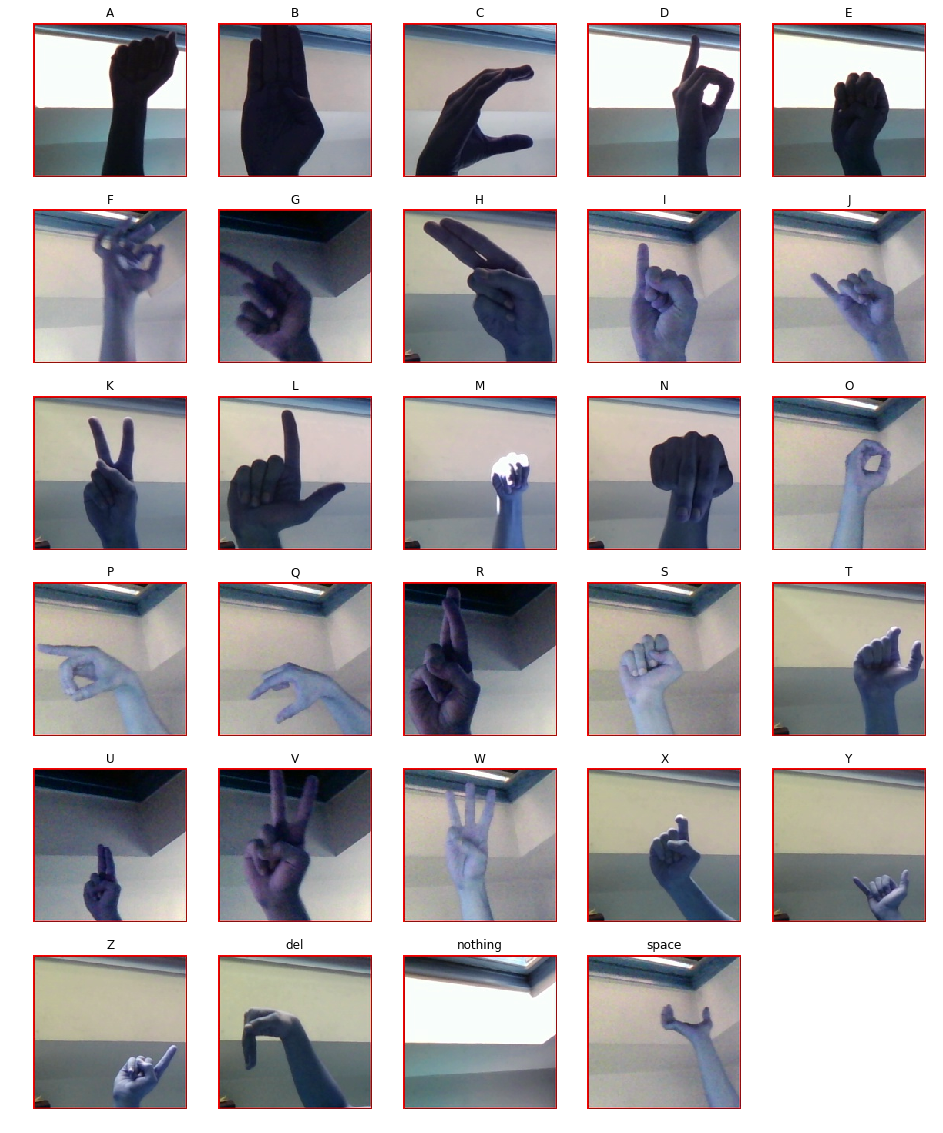

In [0]:
plot_one_sample_of_each(TRAIN_DIR)

#### Conclusion
 
As we can see from the information from the training directory I get the first image of each class and we display the result

## 1st Approach
####Using data augmentation

<p>We create the generator  </p>

In [0]:
train_datagenerator_augmented = ImageDataGenerator(rescale=1./255, vertical_flip = True, rotation_range = 10, zoom_range=0.2, horizontal_flip=True, validation_split= VALIDATION_SPLIT) # set validation split

In [0]:
train_iterator = train_datagenerator_augmented.flow_from_directory(
    TRAIN_DIR,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    subset='training') # set as training data

validation_iterator = train_datagenerator_augmented.flow_from_directory(
    TRAIN_DIR, # same directory as training data
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode= CLASS_MODE,
    subset='validation') # set as validation data

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [0]:
#Model Option 1
def build_model_data_augmentation():
    
    model_augemented = Sequential()
    
    model_augemented.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model_augemented.add(Conv2D(32, kernel_size = 3, padding = 'same', strides = 2, activation = 'relu'))
    model_augemented.add(Dropout(0.5))
    
    model_augemented.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model_augemented.add(Conv2D(64, kernel_size = 3, padding = 'same', strides = 2, activation = 'relu'))
    model_augemented.add(Dropout(0.5))
    
    model_augemented.add(Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model_augemented.add(Conv2D(256, kernel_size = 3, padding = 'same', strides = 2 , activation = 'relu'))
    model_augemented.add(MaxPool2D(3))
    
    model_augemented.add(BatchNormalization())
    
    model_augemented.add(Flatten())
    model_augemented.add(Dropout(0.5))
    model_augemented.add(Dense(512, activation = 'relu'))
    model_augemented.add(Dense(29, activation = 'softmax'))
    
    model_augemented.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model_augemented.summary()
    
    return model_augemented

In [0]:
model = build_model_data_augmentation()

MODEL CREATED
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 

In [0]:
#Model Option 2
inputs = Input(shape=TARGET_DIMS)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(inputs)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
net = LeakyReLU()(net)

net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=1, padding="same")(net)
net = LeakyReLU()(net)
net = Conv2D(32, kernel_size=3, strides=2, padding="same")(net)
net = LeakyReLU()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)
net = Conv2D(filters=32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal')(net)
net = BatchNormalization(axis=3)(net)
net = LeakyReLU()(net)

net = Add()([net, shortcut])

net = GlobalAveragePooling2D()(net)
net = Dropout(0.2)(net)

net = Dense(128, activation='relu')(net)
outputs = Dense(N_CLASSES, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

W0708 10:27:03.139781 140609330575232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 10:27:03.142735 140609330575232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 10:27:03.159295 140609330575232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0708 10:27:03.301438 140609330575232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0708 10:27:03.303322 1406093305

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [0]:
history_augmented = model.fit_generator(
    train_iterator,
    steps_per_epoch = train_iterator.samples // BATCH_SIZE,
    validation_data = validation_iterator, 
    validation_steps = validation_iterator.samples // BATCH_SIZE,
    epochs = N_EPOCHS)

W0901 16:49:52.833672 140232848430976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
1087/1087 [==============================] - 162s 149ms/step - loss: 2.6853 - acc: 0.2102 - val_loss: 2.2371 - val_acc: 0.3429
Epoch 2/30
1087/1087 [==============================] - 157s 145ms/step - loss: 1.2533 - acc: 0.5879 - val_loss: 1.9602 - val_acc: 0.4590
Epoch 3/30
1087/1087 [==============================] - 157s 145ms/step - loss: 0.8003 - acc: 0.7286 - val_loss: 1.2943 - val_acc: 0.6038
Epoch 4/30
1087/1087 [==============================] - 158s 145ms/step - loss: 0.6240 - acc: 0.7868 - val_loss: 1.3661 - val_acc: 0.6305
Epoch 5/30
1087/1087 [==============================] - 157s 144ms/step - loss: 0.5062 - acc: 0.8268 - val_loss: 1.5964 - val_acc: 0.6224
Epoch 6/30
1087/1087 [==============================] - 157s 145ms/step - loss: 0.4496 - acc: 0.8456 - val_loss: 1.5602 - val_acc: 0.6325
Epoch 7/30
1087/1087 [==============================] - 157s 145ms/step - loss: 0.4074 - acc: 0.8597 - val_loss: 0.9918 - val_acc: 0.6979
Epoch 8/30
1087/1087 [============

In [0]:
print('Final Accuracy: {:.2f}%'.format(history_augmented.history['acc'][4] * 100))
print('Validation Set Accuracy: {:.2f}%'.format(history_augmented.history['val_acc'][4] * 100))

NameError: ignored

#### GUARDAMOS EL MODELO

In [0]:
checkpointer = ModelCheckpoint(
    filepath='/content/gdrive/My Drive/Cidaen2/TrabajoFinal/model-option1-dataaugmentation.h5', verbose=0, save_best_only=True)

#####Plot: Cross Entropy Data Augmentation

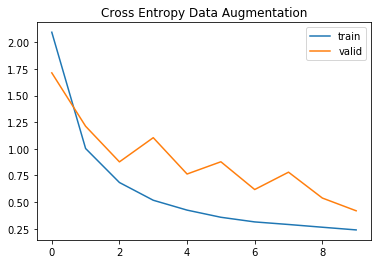

In [0]:
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.legend(['train','valid'])
plt.title('Cross Entropy Data Augmentation')
plt.show()

##### Plot: Accuracy Data Augmentation

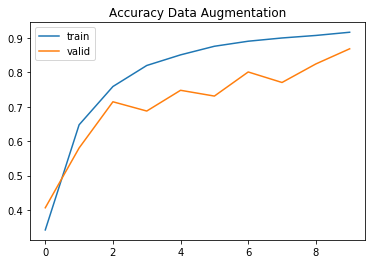

In [0]:
plt.plot(history_augmented.history['acc'])
plt.plot(history_augmented.history['val_acc'])
plt.legend(['train','valid'])
plt.title('Accuracy Data Augmentation')
plt.show()



---




In [0]:
def load_unique():
    size_img = 64,64
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

In [0]:
images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

unique_labels =  ['space', 'M', 'L', 'W', 'B', 'K', 'nothing', 'Y', 'A', 'Z', 'U', 'J', 'F', 'E', 'C', 'H', 'del', 'N', 'I', 'V', 'Q', 'X', 'D', 'T', 'P', 'S', 'O', 'R', 'G']


In [0]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            if folder == 'A':
                labels.append(labels_dict['A'])
            elif folder == 'B':
                labels.append(labels_dict['B'])
            elif folder == 'C':
                labels.append(labels_dict['C'])
            elif folder == 'D':
                labels.append(labels_dict['D'])
            elif folder == 'E':
                labels.append(labels_dict['E'])
            elif folder == 'F':
                labels.append(labels_dict['F'])
            elif folder == 'G':
                labels.append(labels_dict['G'])
            elif folder == 'H':
                labels.append(labels_dict['H'])
            elif folder == 'I':
                labels.append(labels_dict['I'])
            elif folder == 'J':
                labels.append(labels_dict['J'])
            elif folder == 'K':
                labels.append(labels_dict['K'])
            elif folder == 'L':
                labels.append(labels_dict['L'])
            elif folder == 'M':
                labels.append(labels_dict['M'])
            elif folder == 'N':
                labels.append(labels_dict['N'])
            elif folder == 'O':
                labels.append(labels_dict['O'])
            elif folder == 'P':
                labels.append(labels_dict['P'])
            elif folder == 'Q':
                labels.append(labels_dict['Q'])
            elif folder == 'R':
                labels.append(labels_dict['R'])
            elif folder == 'S':
                labels.append(labels_dict['S'])
            elif folder == 'T':
                labels.append(labels_dict['T'])
            elif folder == 'U':
                labels.append(labels_dict['U'])
            elif folder == 'V':
                labels.append(labels_dict['V'])
            elif folder == 'W':
                labels.append(labels_dict['W'])
            elif folder == 'X':
                labels.append(labels_dict['X'])
            elif folder == 'Y':
                labels.append(labels_dict['Y'])
            elif folder == 'Z':
                labels.append(labels_dict['Z'])
            elif folder == 'space':
                labels.append(labels_dict['space'])
            elif folder == 'del':
                labels.append(labels_dict['del'])
            elif folder == 'nothing':
                labels.append(labels_dict['nothing'])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)   #one-hot encoding
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.1)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [0]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : Y | F | M | H | space | R | O | P | L | E | C | I | T | K | del | B | D | Z | N | A | nothing | W | Q | U | J | V | G | S | X | 
Loaded 78300 images for training, Train data shape = (78300, 64, 64, 3)
Loaded 8700 images for testing Test data shape = (8700, 64, 64, 3)


####Building the Model.

In [0]:
def build_model():
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = 3, padding = 'same', strides = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = 3, padding = 'same', strides = 2, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = 3, padding = 'same', strides = 2 , activation = 'relu'))
    model.add(MaxPool2D(3))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(29, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model.summary()
    
    return model

In [0]:
model = build_model()

W0627 08:23:22.421163 139963962222464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0627 08:23:22.426616 139963962222464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0627 08:23:22.439202 139963962222464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0627 08:23:22.481210 139963962222464 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0627 08:23:22.489254 

MODEL CREATED
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        18464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856  

####TRAINING

In [0]:
def fit_model():
    history = model.fit(X_train, Y_train, batch_size = 64, epochs = 5, validation_split = 0.1)
    return history

In [0]:
model_history = fit_model()

W0625 14:20:39.430023 139666257827712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 70470 samples, validate on 7830 samples
Epoch 1/5
70470/70470 [==============================] - 74s 1ms/step - loss: 1.8141 - acc: 0.4450 - val_loss: 3.4362 - val_acc: 0.3006
Epoch 2/5
70470/70470 [==============================] - 70s 992us/step - loss: 0.4846 - acc: 0.8336 - val_loss: 4.1708 - val_acc: 0.3718
Epoch 3/5
70470/70470 [==============================] - 70s 992us/step - loss: 0.2629 - acc: 0.9090 - val_loss: 4.3029 - val_acc: 0.4001
Epoch 4/5
70470/70470 [==============================] - 70s 992us/step - loss: 0.1986 - acc: 0.9322 - val_loss: 1.2531 - val_acc: 0.6875
Epoch 5/5
70470/70470 [==============================] - 70s 993us/step - loss: 0.1468 - acc: 0.9492 - val_loss: 2.0143 - val_acc: 0.6347


In [0]:
if model_history:
    print('Final Accuracy: {:.2f}%'.format(model_history.history['acc'][4] * 100))
    print('Validation Set Accuracy: {:.2f}%'.format(model_history.history['val_acc'][4] * 100))

Final Accuracy: 94.92%
Validation Set Accuracy: 63.47%
